# Homework - Hierarchical Neural Network Construction and Inference
This homework is based on the following manuscript:
> Abhinav Goel, Sara Aghajanzadeh, Caleb Tung, Shuo-Han Chen, George K. Thiruvathukal, and Yung-Hsiang Lu. 2020. Modular Neural Networks for Low-Power Image Classification on Embedded Devices.  ACM Trans. Des. Autom. Electron. Syst. 26, 1, Article 1, 35 pages (https://dl.acm.org/doi/abs/10.1145/3408062)

This method provides a way to build a hierarchy of small neural networks to increase energy efficiency while maintaining high accuracy. In order to determine how the hierarchy should be structured, classes in the dataset that are considered visually similar are grouped together.


#Part 1: Finding Visually Similar Categories

## Setup
> **TASKS:**
> 1. Run these cells to grab the PyPI packages and import the dependencies for the notebook. You can click into the "Files" explorer on the sidebar to confirm that `./untrained_softmax.pth` and `./trained_softmax.pth` were appropriately downloaded.

---

In [ ]:
!pip install gdown
!gdown --id 1aKyr58rOHuQ7jSErj6ZNsV4yXtDETadg -O untrained_softmax.pth
!gdown --id 1wVlw1B4gacTGc6OOZjJUuyhnlfXWmTpy -O trained_softmax.pth

Downloading...
From: https://drive.google.com/uc?id=1aKyr58rOHuQ7jSErj6ZNsV4yXtDETadg
To: /content/untrained_softmax.pth
100% 1.13k/1.13k [00:00<00:00, 1.54MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wVlw1B4gacTGc6OOZjJUuyhnlfXWmTpy
To: /content/trained_softmax.pth
100% 1.13k/1.13k [00:00<00:00, 1.80MB/s]


Check if all files have been properly downloaded and unzipped
Use the following command and check if the following files are present.

```
trained_softmax.pth  untrained_softmax.pth
```

In [ ]:
!ls

sample_data  trained_softmax.pth  untrained_softmax.pth


## Dependencies
Ensure you have all the necessary imports to complete the homework.

In [ ]:
import torch
from collections import OrderedDict, defaultdict
import math
import numpy as np

Please read the following paper for more details about the hierarchy construction using the Averaged Softmax Likelihood Metric:

> Abhinav Goel, Sara Aghajanzadeh, Caleb Tung, Shuo-Han Chen, George K. Thiruvathukal, and Yung-Hsiang Lu. 2020. Modular Neural Networks for Low-Power Image Classification on Embedded Devices.  ACM Trans. Des. Autom. Electron. Syst. 26, 1, Article 1, 35 pages (https://dl.acm.org/doi/abs/10.1145/3408062)






In specific look at Table 3 to see the hierarchy structure built for the CIFAR-10 dataset.

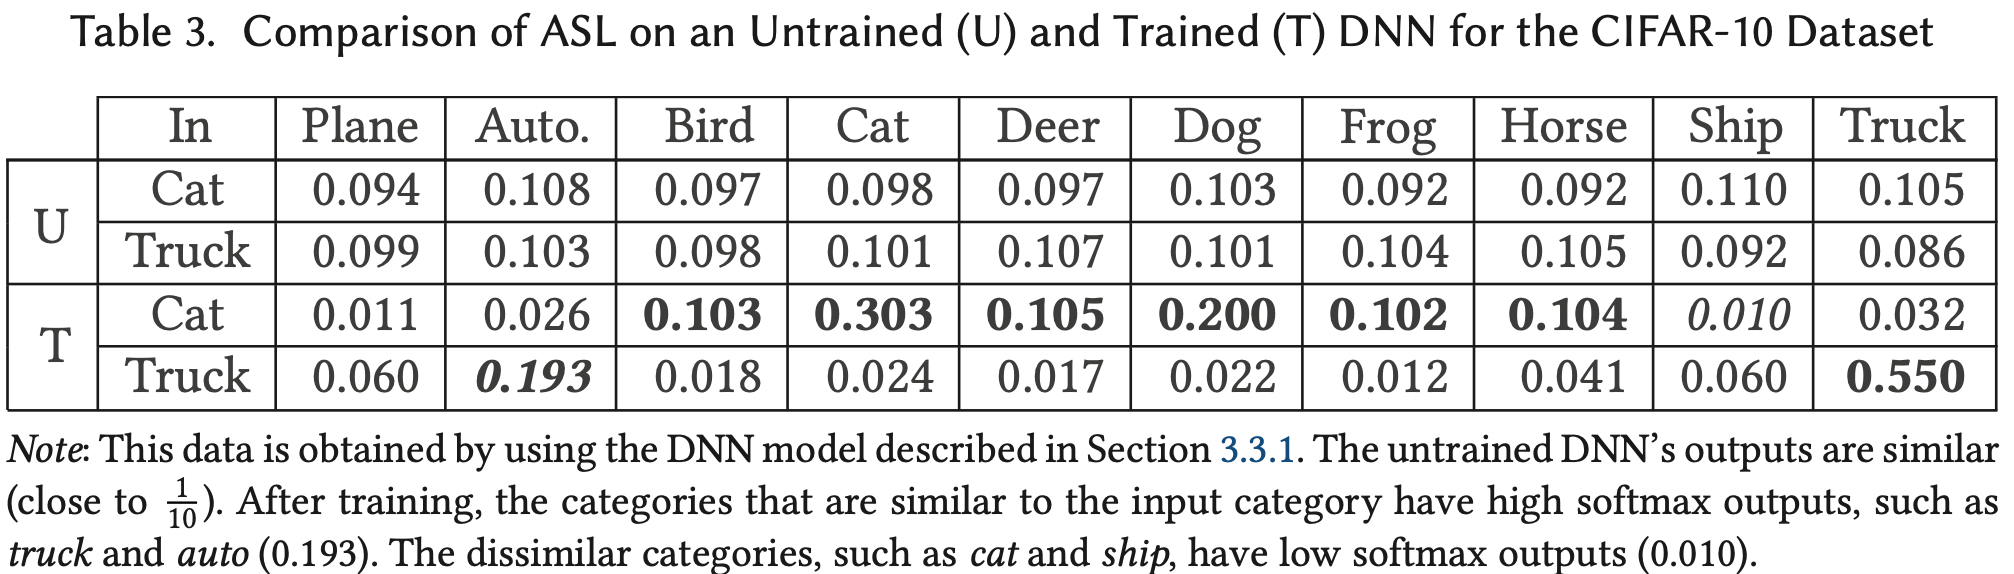

##Problem

The task in this assignment is to use the `./untrained_softmax.pth` and `./trained_softmax.pth` to identify similar categories in the CIFAR-10 dataset.

You will implement part of the averaged softmax likelihood metric to group similar categories together.

There are three TODOs in this part of the homework.

In [ ]:
# First we will load the softmax outputs and verify the shapes.
# There are 10 object categories in the CIFAR-10 dataset. Each category has 10 softmax outputs (one for every class in the dataset)
# The shape of the tensor should be _____ ?

trained_softmax_output = torch.load('trained_softmax.pth')
untrained_softmax_output = torch.load('untrained_softmax.pth')
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len( classes )


### TODO 1: Print shapes of softmax matrices (5%)

Use <tensor>.shape to obtain the shape of the two tensors

In [ ]:
# Use print(<tensor>.shape) for trained_softmax_output
# Use print(<tensor>.shape) for untrained_softmax_output


# Sanity check, do not change this line
assert trained_softmax_output.shape == untrained_softmax_output.shape

#### A portion of the expected output for TODO 1.

`torch.Size([10, 10])`

`torch.Size([10, 10])`



In [ ]:
# Helper functions
def is_visually_similar(softmax_value, number_of_classes = 10):
  """
    Input is a softmax value between two categories
    returns True if categories are similar
    returns False otherwise
  """
  likelihood =  1.0 /( 1.0 + math.exp(-(softmax_value - (1.0/number_of_classes)) / (1.0/(10.0*number_of_classes))) )
  # The purpose of this line in English: Determine if the expected value that two classes are visually similar is greater than 50%
  if np.random.choice(2, 10000, p = [1 - likelihood, likelihood]).mean() > 0.5:
    return True
  else:
    return False

def transitive_grouper(similar_groups):
    """
    Once you have created a list of similar groups.
    This function returns a disjoint set of similar groups.

    You may not need to use this function
    """

    similar_groups_dict = defaultdict(list)
    #create a dictionary from list of similar groups
    for group in similar_groups:
        for category1 in group:
            for category2 in group:
                if category2 not in similar_groups_dict[category1]:
                    similar_groups_dict[category1].append(category2)
                if category1 not in similar_groups_dict[category2]:
                    similar_groups_dict[category2].append(category1)

    #perform transitive grouping
    #If category "A" is similar to category "B" and category "B" is similar to category "C". Then category "A" and "C" should be grouped together along with "B" into same SG in the hierarchy.
    for category in similar_groups_dict:
        for similar_category in similar_groups_dict[category]:
            for similar_to_similar_category in similar_groups_dict[similar_category]:
                if similar_to_similar_category not in similar_groups_dict[category]:
                    similar_groups_dict[category].append(similar_to_similar_category)

    return similar_groups_dict

def print_similar_groups(similar_groups):
  similarities =  transitive_grouper(similar_groups)
  for category in similarities:
    output = "%5s: %4s"%(classes[category], [classes[i] for i in similarities[category]])
    print(output)

### TODO 2: Using untrained softmax output, find groups of similar categories (20%)

At the end `untrained_similar_groups` should look like [[1,2,3], [1,2,5], [6,7,8,9],....]. 

The contents in `untrained_similar_groups[0]` should be the indicies of all the categores that are similar to category 0.

Similarly, `untrained_similar_groups[1]` should contain the indicies of all the categores that are similar to category 1.

Please follow the comments for more details.

In [ ]:
untrained_similar_groups = []

#initialize `untrained_similar_groups`
for i in range(num_classes):
  untrained_similar_groups.append([i]) 

# for each object category in the dataset --> use something like `for class in range(num_classes):`
#     for every other object category in the dataset
#         call `is_visually_similar(untrained_softmax_output[class][<index of other object>])` to check if the two categories have a high averaged softmax likelihood
#         if `is_visually_similar()` returns True
#            add category to the entry using something like: untrained_similar_groups[class].append(<index of other object>)
# call print_similar_groups(untrained_similar_groups) to see output
# a part of the expected output is shown in the following section


#### A portion of the expected output for TODO 2.

`plane: ['plane', 'deer', 'dog', 'ship', 'car', 'frog', 'horse', 'truck', 'bird', 'cat']`

 `deer: ['plane', 'deer', 'dog', 'ship', 'bird', 'car', 'cat', 'horse', 'truck', 'frog']`

### TODO 3: Repeat process for trained softmax output (20%)

At the end `trained_similar_groups` should look like [[1,2,3], [1,2,5], [6,7,8,9],....]. 

The contents in `trained_similar_groups[0]` should be the indicies of all the categores that are similar to category 0.

Similarly, `trained_similar_groups[1]` should contain the indicies of all the categores that are similar to category 1.

Please follow the same steps as TODO 2.

In [ ]:
trained_similar_groups = []
#initialize `trained_similar_groups`
for i in range(num_classes):
  trained_similar_groups.append([i]) 

# follow steps similar to TODO 2.
# call print_similar_groups(untrained_similar_groups) to see output
# a part of the expected output is shown in the following section



#### A portion of the expected output for TODO 3.

`truck: ['car', 'truck']` 

`bird: ['bird', 'cat', 'deer', 'dog', 'frog', 'horse']`


#Part 2: Inference with Hierarchical DNNs

## Setup
> **TASKS:**
> 1. Run these cells to grab the PyPI packages and import the dependencies for the notebook. You can click into the "Files" explorer on the sidebar to confirm that `./models/` and `./trained__weights/` were appropriately downloaded.

---



In [ ]:
!pip install gdown
!gdown --id 1JieDCAANINT5bQ-ouZACCA3Nvpr_gxjZ -O ./trained_weights.zip 
!gdown --id 1q-BI9nodvdWcsj4eixVIl1tjOWXeN5WQ -O models.zip
!unzip ./models.zip
!unzip ./trained_weights

Downloading...
From: https://drive.google.com/uc?id=1JieDCAANINT5bQ-ouZACCA3Nvpr_gxjZ
To: /content/trained_weights.zip
100% 2.19M/2.19M [00:00<00:00, 12.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1q-BI9nodvdWcsj4eixVIl1tjOWXeN5WQ
To: /content/models.zip
100% 5.34k/5.34k [00:00<00:00, 7.63MB/s]
Archive:  ./models.zip
   creating: models/
  inflating: models/.DS_Store        
  inflating: models/SG3.py           
  inflating: models/SG2.py           
  inflating: models/__init__.py      
  inflating: models/SG1.py           
  inflating: models/SG5.py           
  inflating: models/SG4.py           
  inflating: models/root.py          
Archive:  ./trained_weights.zip
   creating: trained_weights/
  inflating: trained_weights/root_saved.pth  
  inflating: trained_weights/root_10112021.pth  
  inflating: trained_weights/root.pth  
  inflating: trained_weights/SG4.pth  
  inflating: trained_weights/SG5.pth  
  inflating: trained_weights/SG2.pth  
  inflating: trained_weight

Check if all files have been properly downloaded and unzipped
Use the following command and check if the following files are present.

```
models  models.zip  trained_weights  trained_weights.zip
```



In [ ]:
!ls

models	    sample_data		 trained_weights      untrained_softmax.pth
models.zip  trained_softmax.pth  trained_weights.zip


## Dependencies
Ensure you have all the necessary imports to complete the homework.

In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import argparse
from torchvision import datasets, transforms
import models           #one of the folders we just downloaded
import trained_weights  #one of the folders we just downloaded

Please read the following paper for more details about the hierarchy structure:

> Abhinav Goel, Sara Aghajanzadeh, Caleb Tung, Shuo-Han Chen, George K. Thiruvathukal, and Yung-Hsiang Lu. 2020. Modular Neural Networks for Low-Power Image Classification on Embedded Devices.  ACM Trans. Des. Autom. Electron. Syst. 26, 1, Article 1, 35 pages (https://dl.acm.org/doi/abs/10.1145/3408062)



In specific look at Figure 8 to see the hierarchy structure built for the CIFAR-10 dataset. Look at Figure 9 to see how to use the hierarchical DNN to perform image classification.

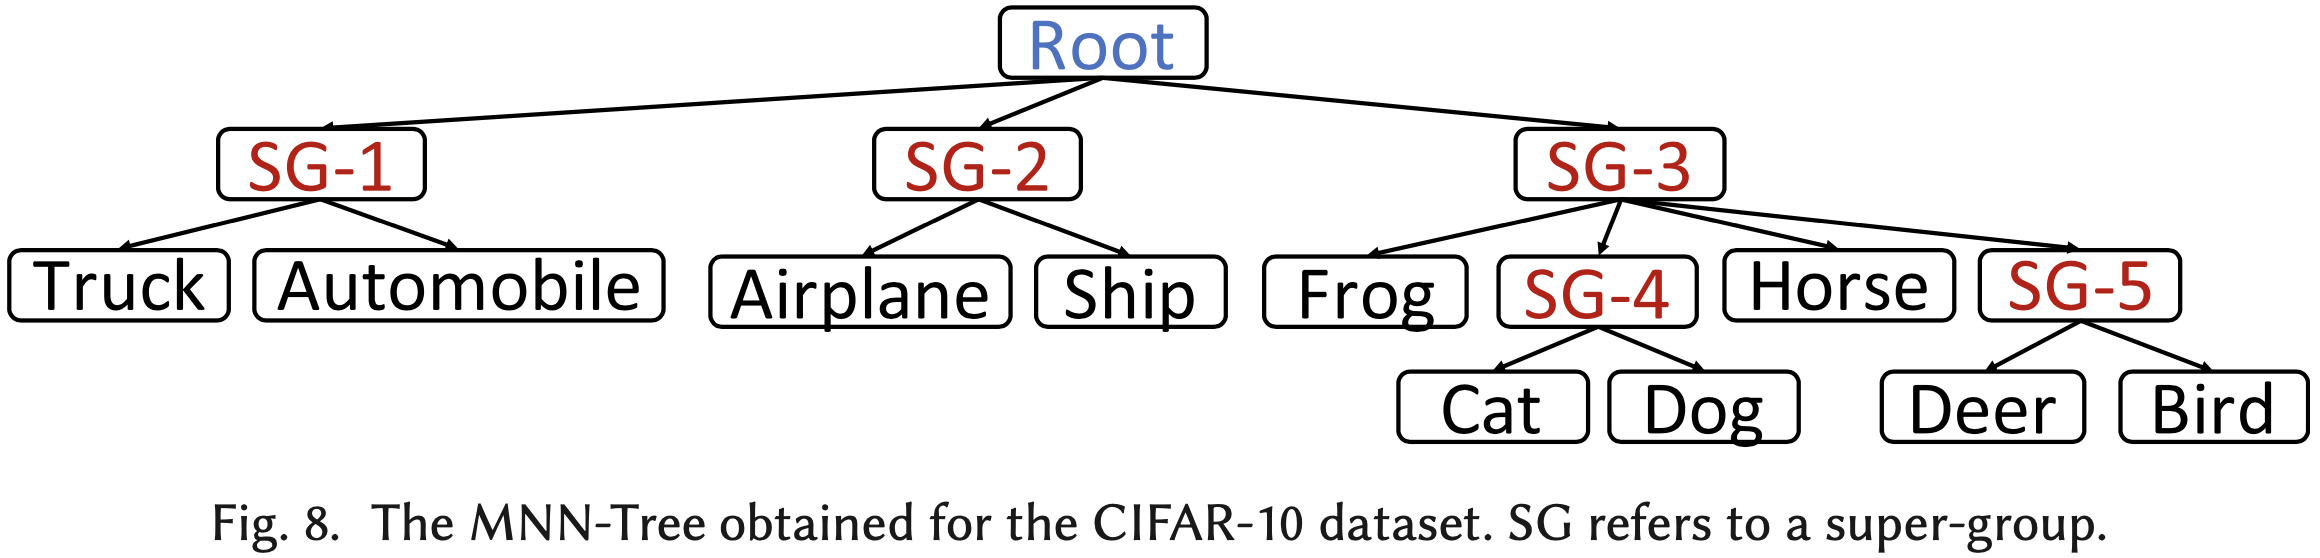

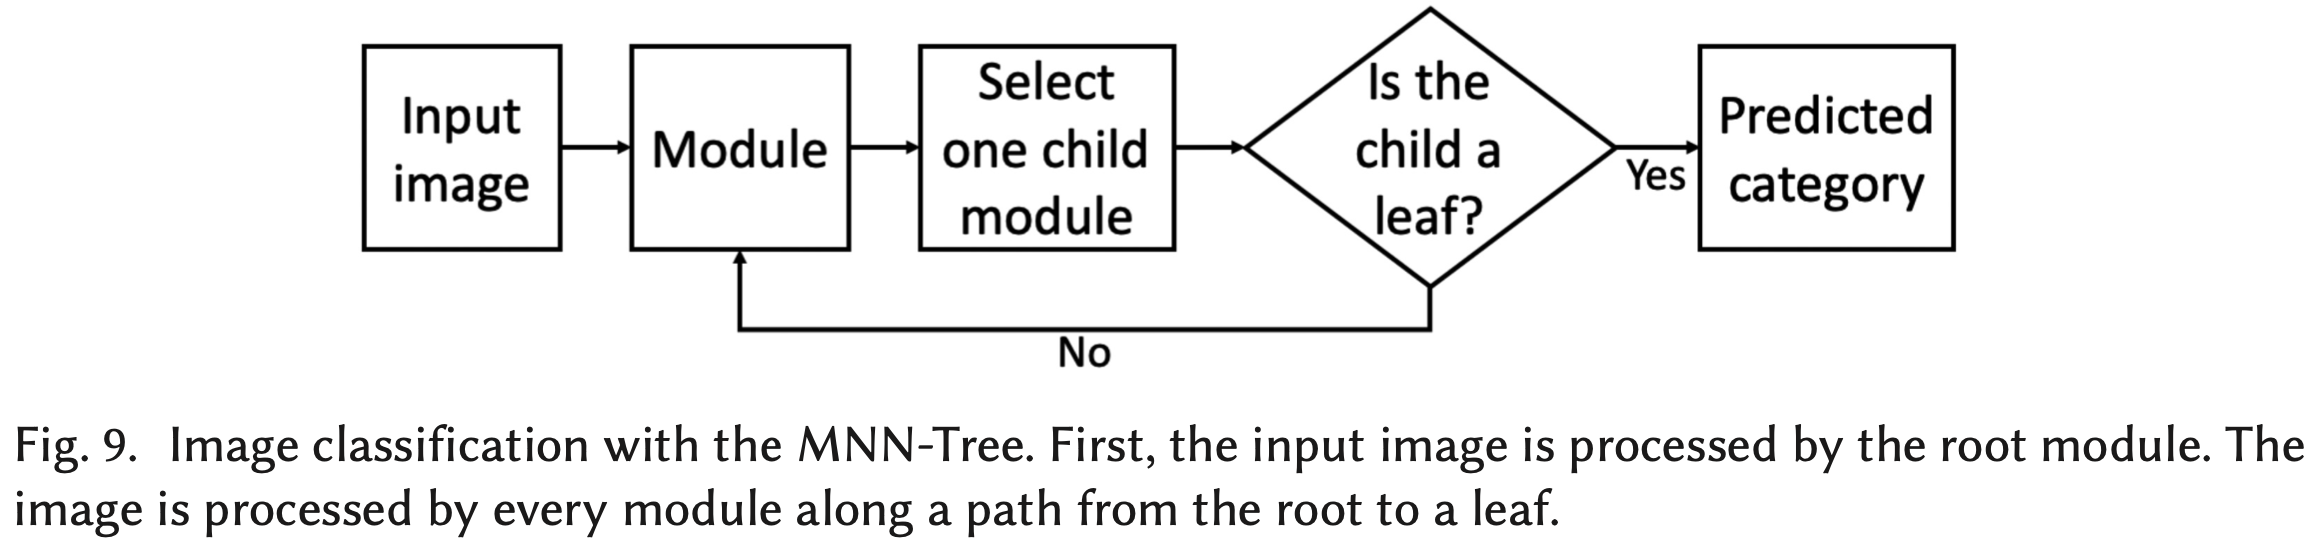

## Problem

Perform inference using a fully constructed and trained Hierarchical DNN.

In [ ]:
# You do not have to make any changes to the `Hierarchy class`. You may need to read through this class to understand the hierarchy structure.
class Hierarchy:
    """
        Defining the structure of the hierarchy used for the CIFAR-10 Dataset.
    """
    def __init__(self, pretrained_path):
        
        self.nodes = ['root', 'SG1', 'SG2', 'SG3', 'SG4', 'SG5'] #There are 6 nodes in the tree as seen in Figure 8 of the paper
        self.leaves = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') #There are 10 object categories in the CIFAR 10 dataset. That means there are 10 leaves in the hierarchy.
        self.valid_paths = [(0,0), (1,0), (2,0,0), (2,1,0), (2,0,1), (2,1,1), (2,2), (2,3), (0,1), (1,1)] #Each leaf has a unique path from the root. To reach 'automobile': we need to obtain output 0 at the 'root' to reach 'SG1'. We then need to also obtain output 0 at 'SG1' to reach 'automobile'.
        self.pretrained_path = pretrained_path


        self.next = {                       #This dictionary mantains the hierarchy structure
            'root': ['SG1', 'SG2', 'SG3'],  #if the output is 0 at the root, we go to 'SG1', if the output is 1 at the root we got 'SG2', if the output is 2 at the root we go to 'SG3'
            'SG1': [None, None],            #None indicates there are no more DNNs to process the data (we have reached a leaf).
            'SG2': [None, None],
            'SG3': ['SG4', 'SG5', None, None],
            'SG4': [None, None],
            'SG5': [None, None],
        }

        self.path_to_leaf = dict(
            zip(
                self.valid_paths,
                self.leaves
            )
        )

        self.path_to_target = dict(
            zip(
                self.valid_paths, 
                list(range(10))
            )
        )
    
    #some helper functions for you to use when traversing the hierarachy
    
    #given a DNN, and the output at the node, return the next DNN of the hierarchy (if any)
    def getNext(self, current_node, child):
        next_child = self.next[current_node][child]
        if next_child == None:
            return None
        return next_child
    
    #return the name of the object category at a particular leaf
    def getLeaf(self, path):
        path = tuple(path)
        if path not in self.path_to_leaf:
            return None
        return self.path_to_leaf[path]

    #return the name object category's encoding to calculate accuracy. For example, in CIFAR-10 'aiplane' is encoded as 0, 'car' is encoded as 1, etc.
    def getTarget(self, path):
        path = tuple(path)
        if path not in self.path_to_target:
            return None
        return self.path_to_target[path]

    #load the DNN into memory and load pre-trained weights
    def getModel(self, DNN_name):
        model = getattr(models, "get_"+DNN_name+"_model")()
        path = os.path.join(self.pretrained_path,DNN_name+'.pth')
        if torch.cuda.is_available():
          model.load_state_dict(torch.load(path))
        else:
          model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
        return model

In [ ]:
# Setting up Pytorch Dataloaders and initializing variables

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

HNN = Hierarchy("trained_weights")
dataset = datasets.CIFAR10(root="cifar-dataset", train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1, sampler = list(range(50)))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar-dataset/cifar-10-python.tar.gz to cifar-dataset


### TODO 4: Tree-based Hierarchical DNN Inference (55%)

You will write a loop that processes the input image by the different DNNs in the hierarchy. You will save the path taken by each image in the `paths` variable.
A part of the expected output is available in the next section.
Please follow the comments for more details.

Please refer the above mentioned paper and the figures to understand how to perform inference with the hierarchical neural network.

In [ ]:
#you will have to write most of this loop to go through the hierarchy and find output for each input image.
#please look at Figure 9 from the paper to understand how to traverse the tree.
correct = 0
for frame_number, (image, label) in enumerate(dataloader):
    current_DNN = 'root'
    path = []
    # write a loop till current_DNN is None
    #   use helper functions to get the appropriate pre-trained DNN models: e.g., model = HNN.<helper function>()
    #   pass the input to the model
    #       IMPORTANT: from paper, we know that the output feature map of the parent DNN is the input to the child DNN. 
    #                  look at forward() of any model in the "models/" directory.
    #                  the forward() function has two outputs:
    #                  the first is the output feature map of the parent.
    #                  the second is the softmax output of the fully-connected layer.
    #                  use something like <feature map>, <softmax out> = model(<image>)
    #                  the next iteration of the loop will use something like: <feature map>, <softmax out> = model(<feature map>)
    #   get the maximum softmax value to identify which path should be taken
    #   use path.append(<maximum softmax value>) to save the path taken by DNN
    #   use helper function to update current_DNN. Something like: current_DNN = HNN.<helper function>(current_DNN, <softmax output>)
    #   tip: use .cBackgrounduda() to run models on GPU if available
    #   tip: run DNNs in eval() mode using model.eval()
    
    ## Write SOLUTION here:
    
    if HNN.getLeaf(path) == classes[label]: #if correct, increment by one
      correct +=1
    output =  'frame number: %2s, predicted label: %6s, ground truth: %6s'%(frame_number, HNN.getLeaf(path),classes[label]) 
    print(output)
print("Accuracy: ", correct/len(dataloader) * 100,"%")

#### Part of the expected output for TODO 4:

`frame number:  0, predicted label:    dog, ground truth:    cat`

`frame number:  1, predicted label:   ship, ground truth:   ship`

`frame number:  2, predicted label:   ship, ground truth:   ship`

`frame number:  3, predicted label:  plane, ground truth:  plane`

`Accuracy: 90.0 %`